## Adam vs Adashift: Logistic Regression on MNIST

In [ ]:
import torch
from torch import nn

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

import adashift.optimizers as ad_opt

import torchvision
import torchvision.transforms as transforms
from torch.nn import functional as F

In [ ]:
input_size = 784
num_classes = 10
num_epochs = 200
batch_size = 64

train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           download=True,
                                           transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,))]))

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.1307,), (0.3081,))]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
import torch.nn as nn

device = torch.device('cuda')

model = nn.Linear(input_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()

In [ ]:
def train(model, device, train_loader, optimizer, num_epochs, criterion, display_iter=1000):
    model.train()
    train_loss_hist = []
    test_acc_hist = []
    test_loss_hist = []
    
    test_loss, test_acc = test(model, device, test_loader, criterion)
    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc)
    
    for epoch in range(num_epochs):  
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.reshape(-1, 28*28))
            loss = criterion(output, target)
            train_loss_hist.append(loss.item())
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                test_loss, test_acc = test(model, device, test_loader, criterion)
                test_loss_hist.append(test_loss)
                test_acc_hist.append(test_acc)

            if batch_idx % display_iter == 0:
                print('Train Epoch: {} TrainLoss: {:.6f}'.format(
                    epoch, loss.item()))

                print('Test set:       TestLoss:  {:.4f}, Accuracy: {:.0f}%'.format(
                    test_loss_hist[-1], test_acc_hist[-1]))

    return train_loss_hist, test_loss_hist, test_acc_hist

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data.reshape(-1, 28*28))
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    return test_loss, acc

**Adam**

In [ ]:
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001,\
                             betas=(0.0, 0.999), eps=1e-8, weight_decay=0)

adam_train_loss_hist, adam_test_loss_hist, adam_test_acc_hist = \
                            train(model, device, train_loader, adam_optimizer, 200, criterion)                

**AmsGrad**

In [ ]:
model = nn.Linear(input_size, num_classes).cuda()

amsgrad_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,\
                             betas=(0.0, 0.999), eps=1e-8, weight_decay=0,amsgrad=True)

amsgrad_train_loss_hist, amsgrad_test_loss_hist, amsgrad_test_acc_hist = \
                            train(model, device, train_loader, amsgrad_optimizer, 200, criterion) 

**max-Adashift**

In [ ]:
model = nn.Linear(input_size, num_classes).cuda()

adashift_optimizer = ad_opt.AdaShift(model.parameters(), lr=1e-2,\
                             betas=(0.0, 0.999), eps=1e-8)

adashift_train_loss_hist, adashift_test_loss_hist, adashift_test_acc_hist = \
                            train(model, device, train_loader, adashift_optimizer, 200, criterion) 

**non-Adashift**

In [ ]:
model = nn.Linear(input_size, num_classes).cuda()

non_adashift_optimizer = ad_opt.AdaShift(model.parameters(), lr=1e-3,\
                             betas=(0.0, 0.999), eps=1e-8, reduce_func=lambda x: x)

non_adashift_train_loss_hist, non_adashift_test_loss_hist, non_adashift_test_acc_hist = \
                            train(model, device, train_loader, non_adashift_optimizer, 200, criterion) 

In [ ]:
def save_as_npy(name, array):
    np_array = np.array([i for i in array]) 
    np.save('logs/log_reg/' + name, np_array)
    return np_array

In [ ]:
adam_train_loss_hist = save_as_npy('adam_train_loss_hist', adam_train_loss_hist)
amsgrad_train_loss_hist = save_as_npy('amsgrad_train_loss_hist', amsgrad_train_loss_hist)
adashift_train_loss_hist = save_as_npy('adashift_train_loss_hist', adashift_train_loss_hist)
non_adashift_train_loss_hist = save_as_npy('non_adashift_train_loss_hist', non_adashift_train_loss_hist)

adam_test_loss_hist = save_as_npy('adam_test_loss_hist', adam_test_loss_hist)
amsgrad_test_loss_hist = save_as_npy('amsgrad_test_loss_hist', amsgrad_test_loss_hist)
adashift_test_loss_hist = save_as_npy('adashift_test_loss_hist', adashift_test_loss_hist)
non_adashift_test_loss_hist = save_as_npy('non_adashift_test_loss_hist', non_adashift_test_loss_hist)

adam_test_acc_hist = save_as_npy('adam_test_acc_hist', adam_test_acc_hist)
amsgrad_test_acc_hist = save_as_npy('amsgrad_test_acc_hist', amsgrad_test_acc_hist)
adashift_test_acc_hist = save_as_npy('adashift_test_acc_hist', adashift_test_acc_hist)
non_adashift_test_acc_hist = save_as_npy('non_adashift_test_acc_hist', non_adashift_test_acc_hist)

In [ ]:
plt.title("MNIST: logistic regression\n Train loss, 1000 iterations")
#np.linspace(0, 1000000, 100),0
plt.plot(adam_train_loss_hist[:1000], label="adam")
plt.plot(amsgrad_train_loss_hist[:1000], label="amsgrad")
plt.plot(adashift_train_loss_hist[:1000], label="max-adashift")
plt.plot(adashift_train_loss_hist[:1000], label="non-adashift")

plt.legend(loc='best')
plt.show()

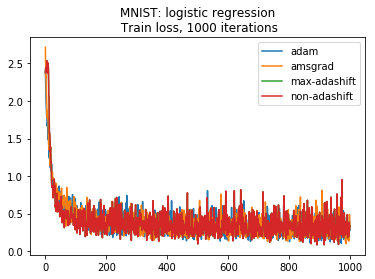

In [ ]:
def smooth(y,box_size,smooth_start=0):
    # borrowed from authors code
    y_hat=np.zeros(y.shape,dtype=y.dtype)
    y_hat[0:smooth_start]=y[0:smooth_start]
    for i in range(smooth_start,y.size):
        if i < smooth_start+box_size//2:
            y_hat[i]=np.mean(y[smooth_start:i+box_size//2])
        elif i<y.size-box_size//2:
            y_hat[i]=np.mean(y[i-box_size//2:i+box_size//2])
        else:
            y_hat[i]=np.mean(y[i-box_size//2:])
    return y_hat

In [ ]:
smooth_size=1000
smooth_start_train_loss=3
issmooth=1

In [ ]:
plt.title("MNIST: logistic regression\n Smoothed train loss")
plt.plot(smooth(adam_train_loss_hist, smooth_size, smooth_start_train_loss), label="adam")
plt.plot(smooth(amsgrad_train_loss_hist, smooth_size, smooth_start_train_loss), label="amsgrad")
plt.plot(smooth(adashift_train_loss_hist, smooth_size, smooth_start_train_loss), label="max-adashift")
plt.plot(smooth(non_adashift_train_loss_hist, smooth_size, smooth_start_train_loss), label="non-adashift")

plt.legend(loc='best')
plt.show()

plt.title("MNIST: logistic regression\n Smoothed train loss, 10000 iterations")

plt.plot(smooth(adam_train_loss_hist[:10000], smooth_size, smooth_start_train_loss), label="adam")
plt.plot(smooth(amsgrad_train_loss_hist[:10000], smooth_size, smooth_start_train_loss), label="amsgrad")
plt.plot(smooth(adashift_train_loss_hist[:10000], smooth_size, smooth_start_train_loss), label="max-adashift")
plt.plot(smooth(non_adashift_train_loss_hist[:10000], smooth_size, smooth_start_train_loss), label="non-adashift")

plt.legend(loc='best')
plt.show()

In [ ]:
plt.title("MNIST: logistic regression\n Test loss")
plt.plot(adam_test_loss_hist, label="adam")
plt.plot(amsgrad_test_loss_hist, label="amsgrad")
plt.plot(adashift_test_loss_hist, label="max-adashift")
plt.plot(non_adashift_test_loss_hist, label="non-adashift")

plt.legend(loc='best')
plt.show()

## MLP

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        self.fc3 = nn.Linear(hidden_size, num_classes) 
        
        with torch.no_grad():
            for p in self.parameters():
                p.data = torch.tensor(np.random.randn(*p.shape).astype(np.float32))
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
#         return F.log_softmax(out, dim=1)
        return out

In [ ]:
hidden_size = 256
criterion = nn.CrossEntropyLoss()

In [ ]:
model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001,\
                             betas=(0.0, 0.999), eps=1e-8, weight_decay=0)

adam_train_loss_hist_mlp, adam_test_loss_hist_mlp, adam_test_acc_hist_mlp = \
                            train(model, device, train_loader, adam_optimizer, 60, criterion)                

In [ ]:
model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

amsgrad_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,\
                             betas=(0.0, 0.999), eps=1e-8, weight_decay=0,amsgrad=True)

amsgrad_train_loss_hist_mlp, amsgrad_test_loss_hist_mlp, amsgrad_test_acc_hist_mlp = \
                            train(model, device, train_loader, amsgrad_optimizer, 60, criterion)               

In [ ]:
from adashift.optimizers import AdaShift

In [ ]:
model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

adashift_optimizer = AdaShift(model.parameters(), lr=1e-2,\
                             betas=(0.0, 0.999), eps=1e-8)

adashift_train_loss_hist_mlp, adashift_test_loss_hist_mlp, adashift_test_acc_hist_mlp = \
                            train(model, device, train_loader, adashift_optimizer, 60, criterion) 

In [ ]:
model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

amsgrad_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,\
                             betas=(0.0, 0.999), eps=1e-8, weight_decay=0,amsgrad=True)

amsgrad_train_loss_hist_mlp, amsgrad_test_loss_hist_mlp, amsgrad_test_acc_hist_mlp =\
        train(model, device, train_loader, amsgrad_optimizer, 60, criterion)               

In [ ]:
model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

non_adashift_optimizer = AdaShift(model.parameters(), lr=1e-3,\
                             betas=(0.0, 0.999), eps=1e-8, reduce_func=lambda x: x)

non_adashift_train_loss_hist_mlp, non_adashift_test_loss_hist_mlp, non_adashift_test_acc_hist_mlp = \
                            train(model, device, train_loader, non_adashift_optimizer, 60, criterion) 

In [ ]:
adam_train_loss_hist_mlp = save_as_npy('adam_train_loss_hist_mlp', adam_train_loss_hist_mlp)
amsgrad_train_loss_hist_mlp = save_as_npy('amsgrad_train_loss_hist_mlp', amsgrad_train_loss_hist_mlp)
adashift_train_loss_hist_mlp = save_as_npy('adashift_train_loss_hist_mlp', adashift_train_loss_hist_mlp)
non_adashift_train_loss_hist_mlp = save_as_npy('non_adashift_train_loss_hist_mlp', non_adashift_train_loss_hist_mlp)

adam_test_loss_hist_mlp = save_as_npy('adam_test_loss_hist_mlp', adam_test_loss_hist_mlp)
amsgrad_test_loss_hist_mlp = save_as_npy('amsgrad_test_loss_hist_mlp', amsgrad_test_loss_hist_mlp)
adashift_test_loss_hist_mlp = save_as_npy('adashift_test_loss_hist_mlp', adashift_test_loss_hist_mlp)
non_adashift_test_loss_hist_mlp = save_as_npy('non_adashift_test_loss_hist_mlp', non_adashift_test_loss_hist_mlp)

adam_test_acc_hist_mlp = save_as_npy('adam_test_acc_hist_mlp', adam_test_acc_hist_mlp)
amsgrad_test_acc_hist_mlp = save_as_npy('amsgrad_test_acc_hist_mlp', amsgrad_test_acc_hist_mlp)
adashift_test_acc_hist_mlp = save_as_npy('adashift_test_acc_hist_mlp', adashift_test_acc_hist_mlp)
non_adashift_test_acc_hist_mlp = save_as_npy('non_adashift_test_acc_hist_mlp', non_adashift_test_acc_hist_mlp)

In [ ]:
smooth_size = 100
plt.title("MNIST: multilayer perceptron\n Smoothed train loss")
plt.plot(smooth(adam_train_loss_hist_mlp, smooth_size, smooth_start_train_loss), label="adam")
plt.plot(smooth(amsgrad_train_loss_hist_mlp, smooth_size, smooth_start_train_loss), label="amsgrad")
plt.plot(smooth(adashift_train_loss_hist_mlp, smooth_size, smooth_start_train_loss), label="max-adashift")
plt.plot(smooth(non_adashift_train_loss_hist_mlp, smooth_size, smooth_start_train_loss), label="non-adashift")
plt.ylim((0, 500))

plt.legend(loc='best')
plt.show()

plt.title("MNIST: multilayer perceptron\n Smoothed train loss, 10000 iterations")

plt.plot(smooth(adam_train_loss_hist_mlp[:10000], smooth_size, smooth_start_train_loss), label="adam")
plt.plot(smooth(amsgrad_train_loss_hist_mlp[:10000], smooth_size, smooth_start_train_loss), label="amsgrad")
plt.plot(smooth(adashift_train_loss_hist_mlp[:10000], smooth_size, smooth_start_train_loss), label="max-adashift")
plt.plot(smooth(non_adashift_train_loss_hist_mlp[:10000], smooth_size, smooth_start_train_loss), label="non-adashift")
plt.ylim((0, 500))

plt.legend(loc='best')
plt.show()

In [ ]:
plt.title("MNIST: multilayer perceptron\n Test loss")
plt.semilogy(adam_test_loss_hist_mlp, label="adam")
plt.semilogy(amsgrad_test_loss_hist_mlp, label="amsgrad")
plt.semilogy(adashift_test_loss_hist_mlp, label="max-adashift")
plt.semilogy(non_adashift_test_loss_hist_mlp, label="non-adashift")
plt.ylim((0, 500))

plt.legend(loc='best')
plt.show()

In [ ]:
plt.title("MNIST: multilayer perceptron\n Test accuracy")
plt.plot(adam_test_acc_hist_mlp, label="adam")
plt.plot(amsgrad_test_acc_hist_mlp, label="amsgrad")
plt.plot(adashift_test_acc_hist_mlp, label="max-adashift")
plt.plot(non_adashift_test_acc_hist_mlp, label="non-adashift")

plt.legend(loc='best')
plt.show()

In [ ]:
plt.title("MNIST: multilayer perceptron\n Test accuracy")
plt.plot(adam_test_acc_hist_mlp, label="adam")
plt.plot(amsgrad_test_acc_hist_mlp, label="amsgrad")
plt.plot(adashift_test_acc_hist_mlp, label="max-adashift")
plt.plot(non_adashift_test_acc_hist_mlp, label="non-adashift")

plt.legend(loc='best')
plt.show()